In [1]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 20.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!ls

adc.json  sample_data


In [0]:
download = drive.CreateFile({'id': '1RVoKzP6IeulTmuLRg6cgsoVEr3RcJAe-'})
download.GetContentFile('d2c_data.tar')


# Loading Images and Normalization

In [14]:
!ls

adc.json      sample_data    x_train.pickle  y_train.pickle
d2c_data.tar  x_test.pickle  y_test.pickle


### Importing Necessary Libraries

In [0]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import xlrd

## Reading 'training.csv'

#### Make a set of Image Names and their corresponding Bounding Box Coordinates

In [0]:
# To get their (images) locations
folder = os.getcwd()
parent = os.path.abspath(os.path.join(folder, os.pardir))
im_loc = [parent, '/images']
im_loc = ''.join(im_loc)

# To get the location of 'training.csv'
data_loc = [parent,'/training.xlsx']
data_loc = ''.join(data_loc)
data = xlrd.open_workbook(data_loc)
sheet = data.sheet_by_index(0) # This will allow us to extract out the image names from 'training.csv'

train = []
image_stack = []
box_stack = []

for i in range(sheet.nrows-1):

    image = sheet.cell_value(i+1,0)
    img_loc = ''.join([im_loc,'/',image])

    exists = os.path.isfile(img_loc)

    # Since we'll later resize the images from 640x480 to 100x100, we have to modify the coordinates accordingly
    sx = 100 
    sy = 100

    x1 = int(np.ceil(((sx/640))*int(sheet.cell_value(i+1,1))))
    x2 = int(np.ceil(((sx/640))*int(sheet.cell_value(i+1,2))))
    y1 = int(np.ceil(((sy/480))*int(sheet.cell_value(i+1,3))))
    y2 = int(np.ceil(((sy/480))*int(sheet.cell_value(i+1,4))))
    
    #Converting the box corner coordinates into center coordinates and box width & height
    w = x2-x1
    h = y2-y1
    x = (x1+x2)/2
    y = (y1+y2)/2
    
    target = [x,y,w,h]
    
    if exists: # Checking if any such image actually xists in the 'images' folder so to save ourselves from future distress
        image_name_stack.append(image)
        box_stack.append(target)
        train.append(image, target)

        # Just for Progress Check
        if np.remainder(i,1000)==0:
            print("{} Images swooped".format(i))

FileNotFoundError: ignored

In [0]:
# Simplifying the 'pickling' process as we'll need this quite often
def pickleIn(name):    
    # 'name' - name of the file we wish to load (should be a string, eg. 'train_batch.pickle')
    pickle_in = open(name,'rb')
    return pickle.load(pickle_in)

def pickleOut(name, to_be_stored):
    # 'name' - name of the file we wish to store (should be a string, eg. 'train_batch.pickle')
    # 'to_be_stored' - the variable of which we'll be making the "pickle" 
    pickle_out = open(name,'wb')
    pickle.dump(to_be_stored, pickle_out)
    pickle_out.close

In [0]:
pickleOut('train.pickle', train) # Makes a pickle out of the variable 'train' and stores into local storage

## Loading Images and Noramlization

In [0]:
loc = "C:\\Users\\npl\\Desktop\\Divyanshu\\Competition\\Dare2Complete\\Round_2\\images\\"

X = [] # To store all the training Images
y = [] # To store all the training targets

i = 0

for image, target in train:
    im_loc = [loc, image] 
    im_loc = ''.join(im_loc)
    
    im = cv2.imread(im_loc, cv2.IMREAD_GRAYSCALE) # Reads the images as grayscale
    im = cv2.resize(im, (100,100)) # Resize from 640x480 to 100x100
    
    X.append(im/255) # Append images into X while also normalizing them (by dividing by 255)
    y.append(target) # Append targets into y
    
    i += 1     

    if np.remainder(i, 500) == 0:
        print(i)

NameError: ignored

#### 'Pickling' of dataset into storage

##### Pickling is done in smaller chunks so that whole RAM isn't used up at once by this particular process. 

In [0]:
pickleOut('X[0_2000].pickle',X[0:2000])

In [0]:
pickleOut('X[2000_4000].pickle',X[2000:4000])

In [0]:
pickleOut('X[4000_6000].pickle',X[4000:6000])

In [0]:
pickleOut('X[6000_8000].pickle',X[6000:8000])

In [0]:
pickleOut('X[8000_10000].pickle',X[8000:10000])

In [0]:
pickleOut('X[10000_12000].pickle',X[10000:12000])

In [0]:
pickleOut('X[12000_14000].pickle',X[12000:14000])

In [0]:
pickleOut('y.pickle',y)

# Training

### Importing Necessary Libraries

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
import keras.backend as K

Using TensorFlow backend.


### Loading X and Y from 'X_and_y.tar'

In [0]:
!tar -x -f d2c_data.tar

In [0]:
''
X = []
for i in range(7):
    name = [loc,'X[',str(2000*i),'_',str(2000*(i+1)),'].pickle']
    name = ''.join(name)
    X.append(pickleIn(name))
    print('Batch {} appended'.format(i))
    
yloc = [loc, 'y.pickle']
yloc = ''.join(yloc)
y = pickleIn(yloc)    

[0.50703125, 0.578125, 0.35156250000000006, 0.7354166666666666]


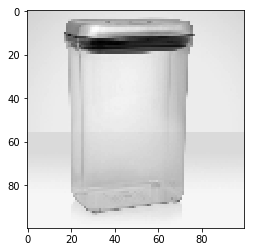

In [0]:
%matplotlib inline
print(y[13999])
plt.imshow(X[6][0].reshape(100,100),cmap='gray')

## Train-Test Set Preparation

### Making of 4-D Array to store images

In [0]:
Whole = np.zeros((14000,100,100,1))

In [0]:
k = 0
for i in range(7):
    for j in range(2000):
        Whole[k,:,:,:] = X[i][j].reshape(100,100,1)
        k += 1

0.6251694117647058


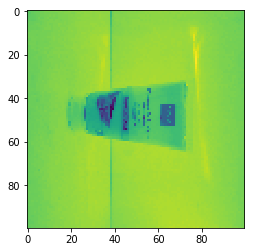

In [0]:
%matplotlib inline
plt.imshow(X[0][0].reshape(100,100))
print(np.mean(Whole[0,:,:,:]))

In [0]:
pickleOut('Whole_4D.pickle', Whole)

In [0]:
Whole = pickleIn('Whole_4D.pickle')

In [0]:
y = pickleIn('y.pickle')

### Converting 'y' from 'list' to 'NumPy array' 

In [0]:
y_ = np.zeros((14000, 4))

for i in range(14000):
    y_[i,0] = y[i][0]
    y_[i,1] = y[i][1]
    y_[i,2] = y[i][2]
    y_[i,3] = y[i][3]

In [0]:
x_train = Whole[0:12000, :,:,:]
x_test = Whole[12000:14000, :,:,:]
y_train = y_[0:12000,:] 
y_test = y_[12000:14000,:]

In [0]:
y_test.shape

(2000, 4)

### Storing Train-Test Set in Local Memory

In [0]:
pickleOut('x_train.pickle', x_train)
pickleOut('y_train.pickle', y_train)
pickleOut('x_test.pickle',  x_test)
pickleOut('y_test.pickle',  y_test)

In [0]:
x_train = pickleIn('x_train.pickle')
y_train = pickleIn('y_train.pickle')
x_test = pickleIn('x_test.pickle')
y_test = pickleIn('y_test.pickle')

In [17]:
!ls


adc.json      sample_data    x_train.pickle  y_train.pickle
d2c_data.tar  x_test.pickle  y_test.pickle


## Our Model(s)

###### Potential IOU Procedures

###### Number 1 (Mine)
'''
Custom Metrics for keras

def iou(y_true, y_pred):
   
    x_t = tf.constant(y_true[0])
    y_t = tf.constant(y_true[1])
    w_t = tf.constant(y_true[2])
    h_t = tf.constant(y_true[3])
    
    # Calculating the Co-ordinates from Center and Length Values (Actual Square)
    x1_t = tf.math.divide(tf.math.subtract(tf.math.multiply(2,x_t),w_t),2)
    y1_t = tf.math.divide(tf.math.subtract(tf.math.multiply(2,y_t),h_t),2)
    x2_t = tf.math.divide(tf.math.add(tf.math.multiply(2,x_t),w_t),2)
    y2_t = tf.math.divide(tf.math.add(tf.math.multiply(2,h_t),h_t),2)
    
    x_p = tf.constant(y_pred[0])
    y_p = tf.constant(y_pred[1])
    w_p = tf.constant(y_pred[2])
    h_p = tf.constant(y_pred[3])
    
    # Calculating the Co-ordinates from center and length values (Prediction Square)
    x1_p = tf.math.divide(tf.math.subtract(tf.math.multiply(2,x_p),w_p),2)
    y1_p = tf.math.divide(tf.math.subtract(tf.math.multiply(2,y_p),h_p),2)
    x2_p = tf.math.divide(tf.math.add(tf.math.multiply(2,x_p),w_p),2)
    y2_p = tf.math.divide(tf.math.add(tf.math.multiply(2,h_p),h_p),2)
    
    # Calculating the co-ordinates of intersecting square
    x1 = tf.maximum((x1_t, x1_p), axis=None, keepdims=False)
    y1 = tf.maximum((y1_t, y1_p), axis=None, keepdims=False)
    x2 = tf.minimum((x2_t, x2_p), axis=None, keepdims=False)
    y2 = tf.minimum((y2_t, y2_p), axis=None, keepdims=False)
    
    # Area of Intersection
    I_area = tf.math.multiply(tf.math.subtract(x2,x1),tf.math.subtract(y2-y1))
    
    true_area = tf.math.multiply(tf.math.subtract(x2_t,x1_t),tf.math.subtract(y2_t,y1_t))
    pred_area = tf.math.multiply(tf.math.subtract(x2_p,x1_p),tf.math.subtract(y2_p,y1_p))
    
    # Union of both regions
    U_area = tf.math.subtract(tf.math.add(true_area, pred_area), I_area)
        
    # Intersection over Union
    IOU = tf.math.divide(I_area,U_area)
    
    return IOU
    
    
'''

###### Number 2 (Chepa hai!!)
'''
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])
'''

### Chepa Hua Model!! ('model')

In [0]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(5, (2, 2), activation='relu'))
model.add(ZeroPadding)
model.add(BatchNormalization())
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1600, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4))

batch_size = 120
epochs = 50

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

TypeError: ignored

In [0]:
model.save('model_0046.h5')

In [0]:
print(iou(y_test[1],s[1]))

0.529822362397252


In [0]:
!ls


adc.json	   x_train_100c_1.pickle  x_train_100c.pickle
d2c_data_100c.tar  x_train_100c_2.pickle  x_train.pickle
d2c_data.tar	   x_train_100c_3.pickle  x_valid_100c.pickle
sample_data	   x_train_100c_4.pickle  y_test.pickle
x_test.pickle	   x_train_100c_5.pickle  y_train.pickle


In [0]:
file5 = drive.CreateFile({'title': 'model_0046.h5'})
file5.SetContentFile('model_0046.h5')
file5.Upload()

We'll be trying out different types of models via exploring their depth and architectures and see which one gives us best results

In [0]:
pred = model.predict(x_test[0:10,:,:,:])

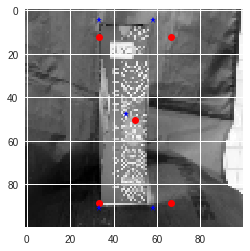

In [0]:
%matplotlib inline

i = 6

some = x_test[i,:,:,:]

plt.imshow(some.reshape(100,100))
plt.plot(100*pred[i,0],100*pred[i,1],'ro')

x1_ = 100*((2*pred[i,0]) - pred[i,2])/2
y1_ = 100*((2*pred[i,1]) - pred[i,3])/2
x2_ = 100*((2*pred[i,0]) + pred[i,2])/2
y2_ = 100*((2*pred[i,1]) + pred[i,3])/2

plt.plot(x1_,y1_,'ro')
plt.plot(x2_,y2_,'ro')
plt.plot(x1_,y2_,'ro')
plt.plot(x2_,y1_,'ro')

plt.plot(100*y_test[i,0],100*y_test[i,1],'b*')

x1_ = 100*((2*y_test[i,0]) - y_test[i,2])/2
y1_ = 100*((2*y_test[i,1]) - y_test[i,3])/2
x2_ = 100*((2*y_test[i,0]) + y_test[i,2])/2
y2_ = 100*((2*y_test[i,1]) + y_test[i,3])/2

plt.plot(x1_,y1_,'b*')
plt.plot(x2_,y2_,'b*')
plt.plot(x1_,y2_,'b*')
plt.plot(x2_,y1_,'b*')

In [0]:
download = drive.CreateFile({'id': '1GZtU-q93cU4woolBU7fCvtw4iLfOaoQo'})
download.GetContentFile('model_0054.h5')

In [0]:
from keras.models import load_model

model_1 = load_model('model_0046.h5')

In [0]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 128)       8320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 282752)            0         
__________

In [0]:
pred = model_1.predict(x_test)

In [0]:
def iou(y_true, y_pred):

  x_t = y_true[0]
  y_t = y_true[1]
  w_t = y_true[2]
  h_t = y_true[3]

  # Calculating the Co-ordinates from Center and Length Values (Actual Square)
  x1_t = ((2*x_t) - w_t)/2
  y1_t = ((2*y_t) - h_t)/2
  x2_t = ((2*x_t) + w_t)/2
  y2_t = ((2*y_t) + h_t)/2

  x_p = y_pred[0]
  y_p = y_pred[1]
  w_p = y_pred[2]
  h_p = y_pred[3]

  # Calculating the Co-ordinates from center and length values (Prediction Square)
  x1_p = ((2*x_p) - w_p)/2
  y1_p = ((2*y_p) - h_p)/2
  x2_p = ((2*x_p) + w_p)/2
  y2_p = ((2*y_p) + h_p)/2

  # Calculating the co-ordinates of intersecting square
  x1 = max(x1_t,x1_p)
  y1 = max(y1_t,y1_p)
  x2 = min(x2_t,x2_p)
  y2 = min(y2_t,y2_p)

  # Area of Intersection
  I_area = (x2-x1)*(y2-y1)

  true_area = (x2_t-x1_t)*(y2_t-y1_t)
  pred_area = (x2_p-x1_p)*(y2_p-y1_p)

  # Union of both regions
  U_area = true_area + pred_area - I_area

  # Intersection over Union
  IOU = I_area/U_area

  return IOU

In [0]:
IOU = np.zeros((8000,1))

for i in range(8000):
  IOU[i,0] = iou(y_test_augment[i,:], pred[i,:])
  
print(np.mean(IOU))

0.8539564250402693


In [0]:
pred_train = model_1.predict(x_train)

In [0]:
IOU_train = np.zeros((12000,1))

for i in range(12000):
  IOU_train[i,0] = iou(y_train[i,:], pred_train[i,:])
  
print(np.mean(IOU_train))

0.8230882491287156


### LeNet-5 ( 'model1' )

# Rang Birangi Duniya

In [0]:
download = drive.CreateFile({'id': '1vQ4kSlnovnVS0Cqtjk3vDtEazdHVYJ3x'})
download.GetContentFile('d2c_data_100c.tar')

In [0]:
!tar -x -f d2c_data_100c.tar

In [0]:
x_train_100c = np.zeros((13500,100,100,3))
for i in range(5):
  if i < 4:
    name  = ['x_train_100c_',str(i+1),'.pickle']
    name = ''.join(name)
    x_train_100c[i*3000:(i+1)*3000, :,:,:] = pickleIn(name)
  else:
    name  = ['x_train_100c_',str(i+1),'.pickle']
    name = ''.join(name)
    x_train_100c[i*3000:13500, :,:,:] = pickleIn(name)
    

In [0]:
x_valid_100c = pickleIn('x_valid_100c.pickle')

In [0]:
y_train = pickleIn('y_train.pickle')
y_test = pickleIn('y_test.pickle')

y_train_100c = np.zeros((13500,4))
y_valid_100c = np.zeros((500,4))

y_train_100c[0:12000,:] = y_train
y_train_100c[12000:13500,:] = y_test[0:1500,:]

y_valid_100c = y_test[1500:2000,:]

In [0]:
pickleOut('x_train_100c.pickle', x_train_100c)

In [0]:
pickleOut('y_train_100c.pickle', y_train_100c)

In [0]:
pickleOut('x_valid_100c.pickle', x_valid_100c)

In [0]:
pickleOut('y_valid_100c.pickle', y_valid_100c)

In [0]:
file5 = drive.CreateFile({'title': 'x_train_100c.pickle'})
file5.SetContentFile('x_train_100c.pickle')
file5.Upload()

In [0]:
file5 = drive.CreateFile({'title': 'y_train_100c.pickle'})
file5.SetContentFile('y_train_100c.pickle')
file5.Upload()

In [0]:
file5 = drive.CreateFile({'title': 'x_valid_100c.pickle'})
file5.SetContentFile('x_valid_100c.pickle')
file5.Upload()

In [0]:
file5 = drive.CreateFile({'title': 'y_valid_100c.pickle'})
file5.SetContentFile('y_valid_100c.pickle')
file5.Upload()

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4))

batch_size = 135
epochs = 50

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train_100c, y_train_100c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_100c, y_valid_100c))
score = model.evaluate(x_valid_100c, y_valid_100c, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.fit(x_train_100c, y_train_100c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_100c, y_valid_100c))
score = model.evaluate(x_valid_100c, y_valid_100c, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model_c.fit(x_train_100c, y_train_100c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_100c, y_valid_100c))
score = model_c.evaluate(x_valid_100c, y_valid_100c, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.save('model_0055_c.h5')

In [0]:
!ls

adc.json	   x_train_100c_1.pickle  x_train.pickle
d2c_data_100c.tar  x_train_100c_2.pickle  x_valid_100c.pickle
d2c_data.tar	   x_train_100c_3.pickle  y_test.pickle
model_0055_c.h5    x_train_100c_4.pickle  y_train_100c.pickle
sample_data	   x_train_100c_5.pickle  y_train.pickle
x_test.pickle	   x_train_100c.pickle	  y_valid_100c.pickle


In [0]:
file5 = drive.CreateFile({'title': 'model_0055_c.h5'})
file5.SetContentFile('model_0055_c.h5')
file5.Upload()

In [0]:
download = drive.CreateFile({'id': '1oRQhWWpv12bfDLshAqEAV5FnAD62L8hU'})
download.GetContentFile('x_train_100c.pickle')

In [0]:
download = drive.CreateFile({'id': '126XjUQ_Q1GqtPqOUtga-lEMslMyr-4d0'})
download.GetContentFile('x_valid_100c.pickle')

In [0]:
download = drive.CreateFile({'id': '1lIYqHESjnGsMZqRAGsHy-cBd9jDRMO9V'})
download.GetContentFile('y_train_100c.pickle')

In [0]:
download = drive.CreateFile({'id': '1Sdx4RLeoEb1rlAWR9HRr2EI7fqrvn7Z4'})
download.GetContentFile('y_valid_100c.pickle')

In [0]:
from keras.models import load_model

model_c = load_model('model_0055_c.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 5)         140       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 10)        460       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 8)         728       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 16)        144       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 10)        2570      
__________

In [0]:
pred_c = model_c.predict(x_valid_100c)

In [0]:
x_valid_100c = pickleIn('x_valid_100c.pickle')
y_valid_100c = pickleIn('y_valid_100c.pickle')

In [0]:
IOU = np.zeros((500,1))

for i in range(500):
  IOU[i,0] = iou(y_valid_100c[i,:], pred_c[i,:])
  
print(np.mean(IOU))

0.7646446908931348


In [0]:
x_train_100c = pickleIn('x_train_100c.pickle')
y_train_100c = pickleIn('y_train_100c.pickle')

In [0]:
pred_pred_c = model_c.predict(x_train_100c)

In [0]:
IOU = np.zeros((13500,1))

for i in range(13500):
  IOU[i,0] = iou(y_train_100c[i,:], pred_pred_c[i,:])
  
print(np.mean(IOU))

0.8164743406875994


In [0]:
print(iou(np.array((4.5,3.5,3,3)),np.array((5.5,4.5,3,3))), float(4/14))

0.2857142857142857 0.2857142857142857


In [0]:
def Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.to_int32(true_labels & pred_labels)
        union = tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.to_int32(true_labels), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

In [0]:
import keras.backend as K
model_c.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Baap Network

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, BatchNormalization, Add, ReLU, AveragePooling2D, ZeroPadding2D, Dropout

In [0]:
input_ = Input(shape = (100,100,1))

layer = ZeroPadding2D(padding=(1, 1), data_format=None)(input_)

layer = Conv2D(5, kernel_size=(2, 2), activation='relu')(layer)
layer = Conv2D(5, (2, 2), activation='relu')(layer)
layer_1 = BatchNormalization()(layer)

layer = ZeroPadding2D(padding=(1, 1), data_format=None)(layer_1)

layer = Conv2D(10, (2, 2), activation='relu')(layer)
layer = Conv2D(10, (2, 2), activation='relu')(layer)
layer = BatchNormalization()(layer)

#Residual_1
res_layer_1 = Conv2D(5, (1, 1), activation = 'relu')(layer)
res_layer_1 = BatchNormalization()(res_layer_1)
res_layer_1 = keras.layers.add([layer_1, res_layer_1])
res_layer_1 = BatchNormalization()(res_layer_1)

layer = AveragePooling2D(pool_size=(2, 2))(res_layer_1)

layer = Conv2D(15, (2, 2), activation='relu')(layer)
layer = Conv2D(15, (2, 2), activation='relu')(layer)
layer_2 = BatchNormalization()(layer)

layer = ZeroPadding2D(padding=(1, 1), data_format=None)(layer_2)

layer = Conv2D(20, (2, 2), activation='relu')(layer)
layer = Conv2D(20, (2, 2), activation='relu')(layer)
layer = BatchNormalization()(layer)

#Residual_2
res_layer_2 = Conv2D(15, (1, 1), activation = 'relu')(layer)
res_layer_2 = BatchNormalization()(res_layer_2)
res_layer_2 = keras.layers.add([layer_2, res_layer_2])
res_layer_2 = Dropout(.2)(res_layer_2)
res_layer_2 = BatchNormalization()(res_layer_2)

layer = AveragePooling2D(pool_size=(2, 2))(res_layer_2)

layer = Conv2D(20, (2, 2), activation='relu')(layer)
layer = Conv2D(20, (2, 2), activation='relu')(layer)
layer_3 = BatchNormalization()(layer)

layer = Conv2D(20, (3, 3), activation='relu')(layer_3)
layer = Conv2D(20, (3, 3), activation='relu')(layer)


layer = Dropout(0.2)(layer)
layer = BatchNormalization()(layer)

layer_4 = AveragePooling2D(pool_size=(2, 2))(layer)
'''
layer = Conv2D(20, (3, 3), activation='relu')(layer_4)
layer_5 = Conv2D(20, (3, 3), activation='relu')(layer)

layer = Conv2D(15, (3, 3), activation='relu')(layer_5)
layer_6 = AveragePooling2D(pool_size=(2, 2))(layer)
'''


layer = Flatten()(layer_4)

layer_7 = Dense(500, activation='relu')(layer)
layer_8 = Dense(500, activation='relu')(layer_7)

layer = Dropout(0.5)(layer_8)

box = Dense(4)(layer)

model = Model(inputs = input_, outputs = box)

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
epochs = 20
batch_size = 480

model.fit(x_train_augment, y_train_augment,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=[1,1,10,10],
          validation_data=(x_test_augment, y_test_augment))

score = model.evaluate(x_test_augment, y_test_augment, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 48000 samples, validate on 8000 samples
Epoch 1/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9314 - val_loss: 0.0029 - val_acc: 0.9139
Epoch 2/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9316 - val_loss: 0.0029 - val_acc: 0.9100
Epoch 3/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9314 - val_loss: 0.0030 - val_acc: 0.9108
Epoch 4/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9317 - val_loss: 0.0029 - val_acc: 0.9104
Epoch 5/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9320 - val_loss: 0.0029 - val_acc: 0.9109
Epoch 6/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9343 - val_loss: 0.0029 - val_acc: 0.9110
Epoch 7/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0011 - acc: 0.9334 - val_loss: 0.0029 - val_acc:

KeyboardInterrupt: ignored

In [0]:
model.save('model_0028_asli.h5')

In [0]:
pred = model.predict(x_test_augment)

In [0]:
IOU = np.zeros((8000,1))

for i in range(8000):
  IOU[i,0] = iou(y_test_augment[i,:], pred[i,:])
  
print(np.mean(IOU))

0.857094674797773


In [0]:
file5 = drive.CreateFile({'title': 'model_0028_asli.h5'})
file5.SetContentFile('model_0028_asli.h5')
file5.Upload()

In [0]:
pred = model.predict(x_train)

In [0]:
import cv2

255


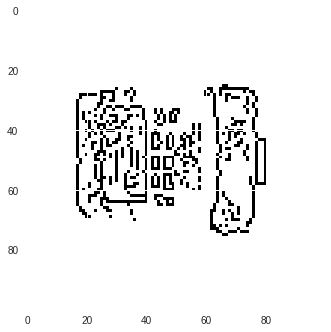

In [0]:
i = 100
img = x_train[i,:,:,:].reshape(100,100)
#plt.imshow(img)
edge = np.uint8(img*255)
img_n = cv2.Canny(edge, 150, 150)
plt.imshow(img_n)
'''sobelx = cv2.Sobel(edge, cv2.CV_64F,1 ,0)
sobely = cv2.Sobel(edge, cv2.CV_64F,1 ,0)'''
#plt.imshow(sobelx)
'''plt.imshow(sobelx)
plt.imshow(sobely)'''
print(np.max(img_n))


In [0]:
x_train_new = np.zeros((12000,100,100,2))
for i in range(12000):
  x_train_new[i,:,:,1] = x_train[i,:,:,0]
  
  img = x_train[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_train_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  
  

500 Images Swooped
1000 Images Swooped
1500 Images Swooped
2000 Images Swooped
2500 Images Swooped
3000 Images Swooped
3500 Images Swooped
4000 Images Swooped
4500 Images Swooped
5000 Images Swooped
5500 Images Swooped
6000 Images Swooped
6500 Images Swooped
7000 Images Swooped
7500 Images Swooped
8000 Images Swooped
8500 Images Swooped
9000 Images Swooped
9500 Images Swooped
10000 Images Swooped
10500 Images Swooped
11000 Images Swooped
11500 Images Swooped
12000 Images Swooped


In [0]:
x_test_new = np.zeros((2000,100,100,2))
for i in range(2000):
  x_test_new[i,:,:,1] = x_test[i,:,:,0]
  
  img = x_test[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_test_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  
  

500 Images Swooped
1000 Images Swooped
1500 Images Swooped
2000 Images Swooped


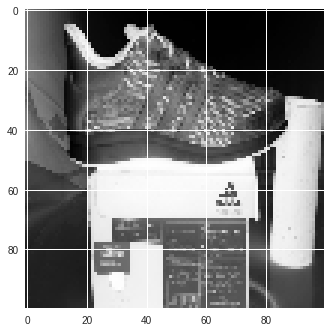

In [0]:
i = 1000
plt.imshow(x_train_new[i,:,:,1])

In [0]:
def iou(y_true, y_pred):

  x_t = y_true[0]
  y_t = y_true[1]
  w_t = y_true[2]
  h_t = y_true[3]

  # Calculating the Co-ordinates from Center and Length Values (Actual Square)
  x1_t = ((2*x_t) - w_t)/2
  y1_t = ((2*y_t) - h_t)/2
  x2_t = ((2*x_t) + w_t)/2
  y2_t = ((2*y_t) + h_t)/2

  x_p = y_pred[0]
  y_p = y_pred[1]
  w_p = y_pred[2]
  h_p = y_pred[3]

  # Calculating the Co-ordinates from center and length values (Prediction Square)
  x1_p = ((2*x_p) - w_p)/2
  y1_p = ((2*y_p) - h_p)/2
  x2_p = ((2*x_p) + w_p)/2
  y2_p = ((2*y_p) + h_p)/2

  # Calculating the co-ordinates of intersecting square
  x1 = max(x1_t,x1_p)
  y1 = max(y1_t,y1_p)
  x2 = min(x2_t,x2_p)
  y2 = min(y2_t,y2_p)

  # Area of Intersection
  I_area = (x2-x1)*(y2-y1)

  true_area = (x2_t-x1_t)*(y2_t-y1_t)
  pred_area = (x2_p-x1_p)*(y2_p-y1_p)

  # Union of both regions
  U_area = true_area + pred_area - I_area

  # Intersection over Union
  IOU = I_area/U_area

  return IOU

In [0]:
IOU = np.zeros((12000,1))

for i in range(12000):
  IOU[i,0] = iou(y_train[i,:], pred[i,:])
  
print(np.mean(IOU))

0.8388981133071848


In [0]:
pred = model.predict(x_test[0:2])

In [0]:
print(pred)

[[0.48346654 0.51633096 0.6494186  0.90200984]
 [0.4870643  0.49060404 0.20642745 0.7383721 ]]


In [0]:
pred[0]

array([0.48346654, 0.51633096, 0.6494186 , 0.90200984], dtype=float32)

In [0]:
%matplotlib inline

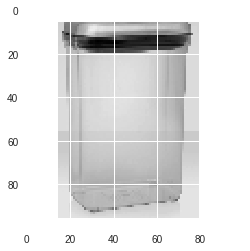

In [0]:
frame = convert(x_test[0],pred[0])

plt.imshow(frame.reshape(100,100), cmap = 'gray')

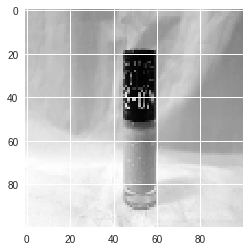

In [0]:
plt.imshow(x_test[0].reshape(100,100), cmap = 'gray')

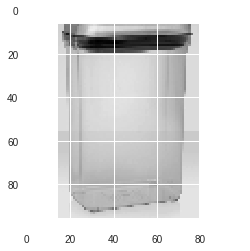

In [0]:
plt.imshow(convert(frame, model.predict(frame.reshape(1,100,100,1))[0]).reshape(100,100), cmap = 'gray')

In [0]:
print("First ",iou(y_test[0],pred[0]))

0.8753181096985279


In [0]:
print("Second ",iou(y_test[0],model.predict(frame.reshape(1,100,100,1))[0]))

0.8413231810674435


In [0]:
import time

In [0]:
n = 12000
win_count = 0
start = time.time()
for i in range(n):
  pred = model.predict(x_train[i].reshape(1,100,100,1))
  frame = convert(x_train[i],pred[0])
  """print("First ",iou(y_test[i],pred[0]))
  print("Second ",iou(y_test[i],model.predict(frame.reshape(1,100,100,1))[0]))

  print("\n\n")"""
  
  if iou(y_train[i],pred[0]) > iou(y_train[i],model.predict(frame.reshape(1,100,100,1))[0]):
    #print("You LOSE by Margin: {} ".format(iou(y_test[i],pred[0]) - iou(y_test[i],model.predict(frame.reshape(1,100,100,1))[0])))
    pass
  else:
    win_count += 1
    #print("You WIN by Margin: {}".format(-iou(y_test[i],pred[0]) + iou(y_test[i],model.predict(frame.reshape(1,100,100,1))[0])))
    
  
end = time.time()
print("\n\nWIN Percentage: {}%".format((win_count/n)*100))

print("\n\nTook {} seconds to do go over {} images TWICE".format(end-start, n))
   

    
  



WIN Percentage: 24.933333333333334%


Took 80.41637516021729 seconds to do go over 12000 images TWICE


In [0]:
def convert(image, coord):
  
  width = 100
  height = 100
  
  frame = np.ones((width,height,1))
  
  y_true = coord
  x_t = y_true[0]
  y_t = y_true[1]
  w_t = y_true[2]
  h_t = y_true[3]

  # Calculating the Co-ordinates from Center and Length Values (Actual Square)
  x1_t = int(width*(((2*x_t) - w_t)/2))
  y1_t = int(height*(((2*y_t) - h_t)/2))
  x2_t = int(width*(((2*x_t) + w_t)/2))
  y2_t = int(height*(((2*y_t) + h_t)/2))
  
  frame = frame.reshape(100,100)
  
  frame[y1_t:y2_t, x1_t:x2_t] = image.reshape(100,100)[y1_t:y2_t, x1_t:x2_t]
  
  frame = frame.reshape(100,100,1)
  
  return frame

In [0]:
epochs = 30
batch_size = 120

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
epochs = 60
batch_size = 120

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
pred = model.predict(x_test)

IOU = np.zeros((2000,1))

for i in range(2000):
  IOU[i,0] = iou(y_test[i,:], pred[i,:])
  
print(np.mean(IOU))

0.8140635170769276


In [0]:
pred = model.predict(x_train)

IOU = np.zeros((12000,1))

for i in range(12000):
  IOU[i,0] = iou(y_train[i,:], pred[i,:])
  
print(np.mean(IOU))

0.860727947936603


# Network of Models

In [0]:
input_ = Input(shape = (100,100,1))

# Sub-Model_1

layer = Conv2D(5, (5,5), activation = 'relu')(input_)
layer = Conv2D(10, (5,5), activation = 'relu')(layer)
layer = Conv2D(15, (5,5), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (5,5), activation = 'relu')(layer)
layer = Conv2D(15, (5,5), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (5,5), activation = 'relu')(layer)
layer = Conv2D(15, (5,5), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = Dropout(.3)(layer)

layer = Flatten()(layer)

layer = Dense(150, activation = 'relu')(layer)
layer_1 = Dense(75, activation = 'relu')(layer)

# Sub-Model_2

layer = ZeroPadding2D(padding = (1,1))(input_)

layer = Conv2D(5, (3,3), activation = 'relu')(layer)
layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = Dropout(.3)(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Flatten()(layer)

layer_2 = Dense(300, activation = 'relu')(layer)

# Sub-Model_3

layer = ZeroPadding2D(padding = (1,1))(input_)

layer = Conv2D(5, (3,3), activation = 'relu')(layer)
layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

## Residual Layer
res_layer = ReLU()(layer)
res_layer = Conv2D(15, (3,3), activation = 'relu', padding = 'same')(res_layer)
layer = keras.layers.add([layer, res_layer])

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)
layer = BatchNormalization()(layer)

layer = Conv2D(10, (3,3), activation = 'relu')(layer)
layer = Conv2D(15, (3,3), activation = 'relu')(layer)

layer = Dropout(.3)(layer)
layer = BatchNormalization()(layer)

layer = AveragePooling2D(pool_size=(2, 2))(layer)

layer = Flatten()(layer)

layer_3 = Dense(300, activation = 'relu')(layer)

# Merging _2 and _3 last Dense layer
layer = keras.layers.add([layer_2, layer_3])
layer = Dense(150, activation = 'relu')(layer)
layer = Dropout(.3)(layer)
layer_2_3 = Dense(75, activation = 'relu')(layer)

# Merging _2_3 and _1 last Dense layer
layer_1_2_3 = keras.layers.add([layer_1, layer_2_3])

# Merging the predictions
layer = Dense(25, activation = 'relu')(layer_1_2_3)
layer = Dropout(.3)(layer)
box = Dense(4)(layer)

In [0]:
model_net = Model(inputs = input_, outputs = box)

model_net.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

NameError: ignored

In [0]:
model_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 100, 100, 5)  50          zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 98, 98, 10)   460         conv2d_17[0][0]                  
__________________________________________________________________________________________________
zero_paddi

In [0]:
epochs = 50
batch_size = 120

model_net.fit(x_train_augment[:,:,:,0:1], y_train_augment,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_augment[:,:,:,0:1], y_test_augment))

score = model_net.evaluate(x_test_augment[:,:,:,0:1], y_test_augment, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: ignored

# Nayi Shuruwaat

In [0]:
download = drive.CreateFile({'id': '1GZtU-q93cU4woolBU7fCvtw4iLfOaoQo'})
download.GetContentFile('model_0038_83_1.h5')

from keras.models import load_model

model_1 = load_model('model_0038_83_1.h5')

In [0]:
def augment(image, angle):
  
  rows,cols = image.shape
  
  image = image*255
  
  M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
  
  dst = cv2.warpAffine(image,M,(cols,rows))

  
  return dst

In [0]:
np.max(augment(x_train[0,:,:,0],90))

100 100
196.0
100.0
196.0


196.0

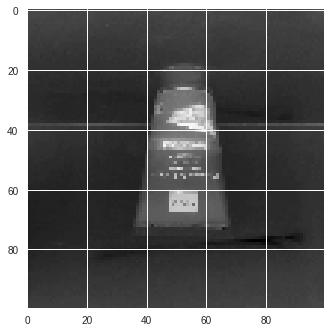

In [0]:
plt.imshow(augment(x_train[0].reshape(100,100),270))

In [0]:
x_train_augment = np.zeros((48000,100,100,1))

for i in range(12000):
  
  x_train_augment[i,:,:,:] = x_train[i]
  x_train_augment[i+12000,:,:,:] = (augment(x_train[i,:,:,0],90)/255).reshape(100,100,1)
  x_train_augment[i+24000,:,:,:] = (augment(x_train[i,:,:,0],180)/255).reshape(100,100,1)
  x_train_augment[i+36000,:,:,:] = (augment(x_train[i,:,:,0],270)/255).reshape(100,100,1)
  
  if np.remainder(i+1,500)==0:
    print("{} Imgaes swooped".format(i+1))
  
  

500 Imgaes swooped
1000 Imgaes swooped
1500 Imgaes swooped
2000 Imgaes swooped
2500 Imgaes swooped
3000 Imgaes swooped
3500 Imgaes swooped
4000 Imgaes swooped
4500 Imgaes swooped
5000 Imgaes swooped
5500 Imgaes swooped
6000 Imgaes swooped
6500 Imgaes swooped
7000 Imgaes swooped
7500 Imgaes swooped
8000 Imgaes swooped
8500 Imgaes swooped
9000 Imgaes swooped
9500 Imgaes swooped
10000 Imgaes swooped
10500 Imgaes swooped
11000 Imgaes swooped
11500 Imgaes swooped
12000 Imgaes swooped


In [0]:
x_test_augment = np.zeros((8000,100,100,1))

for i in range(2000):
  
  x_test_augment[i,:,:,:] = x_test[i]
  x_test_augment[i+2000,:,:,:] = (augment(x_test[i,:,:,0],90)/255).reshape(100,100,1)
  x_test_augment[i+4000,:,:,:] = (augment(x_test[i,:,:,0],180)/255).reshape(100,100,1)
  x_test_augment[i+6000,:,:,:] = (augment(x_test[i,:,:,0],270)/255).reshape(100,100,1)
  
  if np.remainder(i+1,500)==0:
    print("{} Imgaes swooped".format(i+1))
  
  

500 Imgaes swooped
1000 Imgaes swooped
1500 Imgaes swooped
2000 Imgaes swooped


In [0]:
pickleOut("x_train_augment_1.pickle", x_train_augment[0:12000])

In [0]:
pickleOut("x_train_augment_2.pickle", x_train_augment[12000:24000])

In [0]:
pickleOut("x_train_augment_3.pickle", x_train_augment[24000:36000])

In [0]:
pickleOut("x_train_augment_4.pickle", x_train_augment[36000:48000])

In [0]:
pickleOut("x_test_augment.pickle", x_test_augment)

In [0]:
file5 = drive.CreateFile({'title': 'x_train_augment_1.pickle'})
file5.SetContentFile('x_train_augment_1.pickle')
file5.Upload()



In [0]:
file5 = drive.CreateFile({'title': 'x_train_augment_2.pickle'})
file5.SetContentFile('x_train_augment_2.pickle')
file5.Upload()



In [0]:
file5 = drive.CreateFile({'title': 'x_train_augment_3.pickle'})
file5.SetContentFile('x_train_augment_3.pickle')
file5.Upload()



In [0]:
file5 = drive.CreateFile({'title': 'x_train_augment_4.pickle'})
file5.SetContentFile('x_train_augment_4.pickle')
file5.Upload()



In [0]:
file5 = drive.CreateFile({'title': 'x_test_augment.pickle'})
file5.SetContentFile('x_test_augment.pickle')
file5.Upload()

In [0]:
def augment_y(coord, angle):
  
  x = coord[0]
  y = coord[1]
  w = coord[2]
  h = coord[3]
  
  if angle == 90 or angle == 270:
    w_new = h
    h_new = w
    
  if angle == 90:
    x_new = y
    y_new = 1 - x
    
  if angle == 180:
    x_new = 1 - x
    y_new = 1 - y
    w_new = w
    h_new = h
    
    
  if angle == 270:
    x_new = 1 - y
    y_new = x
  
  
  coord_new = 0*coord
  
  coord_new[0] = x_new
  coord_new[1] = y_new
  coord_new[2] = w_new
  coord_new[3] = h_new
  
  return coord_new

In [0]:
sample_y = augment_y(y_train[0],180)

In [0]:
sample_x = augment(x_train[0,:,:,0],180)

In [0]:
def draw(sample_x, sample_y):
  x_ = sample_y[0]
  y_ = sample_y[1]
  w_ = sample_y[2]
  h_ = sample_y[3]

  x1 = int(100*((2*x_) - w_)/2)
  y1 = int(100*((2*y_) - h_)/2)
  x2 = int(100*((2*x_) + w_)/2)
  y2 = int(100*((2*y_) + h_)/2)

  #cv2.rectangle(sample_x*255, (x1,y1),(x2,y2),(255),2)
  
  plt.imshow(sample_x,cmap ='gray')
  #plt.hold()
  plt.plot(x1,y1,'ro')
  plt.plot(x2,y2,'ro')

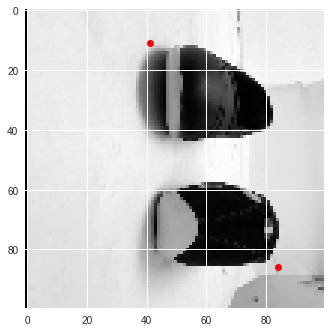

In [0]:
i = 36000
j = 140
draw(x_train_augment[i+j,:,:,0], y_train_augment[i+j])

In [0]:
def augment(image, angle):
  
  rows,cols = image.shape
  
  image = image*255
  
  M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
  
  dst = cv2.warpAffine(image,M,(cols,rows))

  
  return dst

In [0]:
y_train_augment = np.zeros((48000,4))

for i in range(12000):
  
  y_train_augment[i,:] = y_train[i]
  y_train_augment[i+12000,:] = (augment_y(y_train[i,:],90))
  y_train_augment[i+24000,:] = (augment_y(y_train[i,:],180))
  y_train_augment[i+36000,:] = (augment_y(y_train[i,:],270))
  
  if np.remainder(i+1,500)==0:
    print("{} Imgaes swooped".format(i+1))
  

500 Imgaes swooped
1000 Imgaes swooped
1500 Imgaes swooped
2000 Imgaes swooped
2500 Imgaes swooped
3000 Imgaes swooped
3500 Imgaes swooped
4000 Imgaes swooped
4500 Imgaes swooped
5000 Imgaes swooped
5500 Imgaes swooped
6000 Imgaes swooped
6500 Imgaes swooped
7000 Imgaes swooped
7500 Imgaes swooped
8000 Imgaes swooped
8500 Imgaes swooped
9000 Imgaes swooped
9500 Imgaes swooped
10000 Imgaes swooped
10500 Imgaes swooped
11000 Imgaes swooped
11500 Imgaes swooped
12000 Imgaes swooped


In [0]:
pickleOut("y_train_augment.pickle", y_train_augment)

In [0]:
file5 = drive.CreateFile({'title': 'y_train_augment.pickle'})
file5.SetContentFile('y_train_augment.pickle')
file5.Upload()

In [0]:
y_test_augment = np.zeros((8000,4))

for i in range(2000):
  
  y_test_augment[i,:] = y_test[i]
  y_test_augment[i+2000,:] = (augment_y(y_test[i,:],90))
  y_test_augment[i+4000,:] = (augment_y(y_test[i,:],180))
  y_test_augment[i+6000,:] = (augment_y(y_test[i,:],270))
  
  if np.remainder(i+1,500)==0:
    print("{} Imgaes swooped".format(i+1))
  

500 Imgaes swooped
1000 Imgaes swooped
1500 Imgaes swooped
2000 Imgaes swooped


In [0]:
pickleOut("y_test_augment.pickle", y_test_augment)

In [0]:
file5 = drive.CreateFile({'title': 'y_test_augment.pickle'})
file5.SetContentFile('y_test_augment.pickle')
file5.Upload()

FileNotFoundError: ignored

In [20]:
download = drive.CreateFile({'id': '1B94DtiC5of0T-H5O9vFKxeEC8e3aLd6_'})
download.GetContentFile('x_test_augment.pickle')


InvalidConfigError: ignored

In [0]:
download = drive.CreateFile({'id': '1CeAX5A0n_DZKPIAx8UkYKELZv7l7knP6'})
download.GetContentFile('x_train_augment_1.pickle')


In [0]:
download = drive.CreateFile({'id': '1f42puyFLvPb6KOKQ_4oAVAB-1roeTtVS'})
download.GetContentFile('x_train_augment_2.pickle')


In [0]:
download = drive.CreateFile({'id': '1FCmYv3mW-UZjhwtb_2_KU_TT5A7nIFQR'})
download.GetContentFile('x_train_augment_3.pickle')


In [0]:
download = drive.CreateFile({'id': '1rBXW_AunXaWA-LR0KMRql1zcYVZzjkjU'})
download.GetContentFile('x_train_augment_4.pickle')


In [0]:
download = drive.CreateFile({'id': '1CxlBGwO1PvU5X29DyhB_WfEMPCbcHqUq'})
download.GetContentFile('y_test_augment.pickle')

In [0]:
download = drive.CreateFile({'id': '13MoAdZrwWS8haMlLaIe13Nc5xMPNSXXz'})
download.GetContentFile('y_train_augment.pickle')

In [0]:
download = drive.CreateFile({'id': '1Ed81aWjZ_tH_CdjbC7j2RddalnuWYpmh'})
download.GetContentFile('model_0038_83_1.h5')

In [0]:
x_train_augment_new = np.zeros((48000,100,100,2))
for i in range(12000):
  x_train_augment_new[i,:,:,1] = x_train_augment[i,:,:,0]
  
  img = x_train_augment[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_train_augment_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  
  

In [0]:
for i in range(12000:24000):
  x_train_augment_new[i,:,:,1] = x_train_augment[i,:,:,0]
  
  img = x_train_augment[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_train_augment_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  


In [0]:
for i in range(24000:36000):
  x_train_augment_new[i,:,:,1] = x_train_augment[i,:,:,0]
  
  img = x_train_augment[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_train_augment_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  


In [0]:
for i in range(36000:48000):
  x_train_augment_new[i,:,:,1] = x_train_augment[i,:,:,0]
  
  img = x_train_augment[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_train_augment_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  


In [0]:
for i in range(8000):
  x_test_augment_new[i,:,:,1] = x_test_augment[i,:,:,0]
  
  img = x_test_augment[i,:,:,:].reshape(100,100) 
  edge = cv2.Canny(np.uint8(img*255), 150, 150)/255
  
  edge = edge.reshape(100,100)
  
  x_test_augment_new[i,:,:,0] = edge
  
  if np.remainder(i+1,500)==0:
    print("{} Images Swooped".format(i+1))
  


500 Images Swooped
1000 Images Swooped
1500 Images Swooped
2000 Images Swooped
2500 Images Swooped
3000 Images Swooped
3500 Images Swooped
4000 Images Swooped
4500 Images Swooped
5000 Images Swooped
5500 Images Swooped
6000 Images Swooped
6500 Images Swooped
7000 Images Swooped
7500 Images Swooped
8000 Images Swooped


In [0]:
x_test_augment_new = np.zeros((8000,100,100,2))

In [0]:
x_train_augment = np.zeros((48000,100,100,1))

In [0]:
x_train_augment[0:12000] = pickleIn("x_train_augment_1.pickle")

In [0]:
x_train_augment[12000:24000] = pickleIn("x_train_augment_2.pickle")

In [0]:
x_train_augment[24000:36000] = pickleIn("x_train_augment_3.pickle")

In [0]:
x_train_augment[36000:48000] = pickleIn("x_train_augment_4.pickle")

In [0]:
x_test_augment = np.zeros((8000,100,100,1))

In [0]:
x_test_augment = pickleIn("x_test_augment.pickle")

In [0]:
y_train_augment = np.zeros((48000, 4))
y_test_augment = np.zeros((8000, 4))

In [0]:
y_train_augment = pickleIn("y_train_augment.pickle")
y_test_augment = pickleIn("y_test_augment.pickle")

In [0]:
!ls

adc.json	       x_train_augment_1.pickle  y_test_augment.pickle
d2c_data.tar	       x_train_augment_2.pickle  y_train_augment.pickle
sample_data	       x_train_augment_3.pickle
x_test_augment.pickle  x_train_augment_4.pickle


In [0]:
from keras.models import load_model

model_1 = load_model('model_0038_83_1.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model = Sequential()
model.add(ZeroPadding2D(padding = (1,1)))
for layer in model_1.layers[2:-3]:
  model.add(layer)
  

NameError: ignored

In [7]:
model = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 0s 0us/step


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________